### Sentiment Analysis with BERT for Twitter Dataset
### This notebook implements a BERT-based classifier to predict sentiment (positive, negative, neutral) from Twitter posts, as per the 7PAM2015 Research Methods assignment.
### The code includes data preprocessing, model fine-tuning, evaluation, and visualization.

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from datasets import Dataset

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 1. Load and preprocess the dataset

In [20]:
# Load the Twitter dataset from CSV
tweets_data = pd.read_csv("Tweets.csv")

In [21]:
# Checking the Head of the Dataset
tweets_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [22]:
# Checking the Structure of the Dataset
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [23]:
# Remove beginning/ending quotes from text and selected_text columns
tweets_data['text'] = tweets_data['text'].str.strip('"')
tweets_data['selected_text'] = tweets_data['selected_text'].str.strip('"')

In [24]:
# Handle missing values (drop rows with NaN in text or sentiment)
tweets_data = tweets_data.dropna(subset=['text', 'sentiment'])

In [25]:
# Map sentiment labels to integers
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
tweets_data['label'] = tweets_data['sentiment'].map(sentiment_mapping)

### 2. Prepare dataset for BERT

In [26]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [32]:
# Tokenize text data
def tokenize_data(data):
    """
    Tokenizes text data using BERT tokenizer.
    Args:
        data: Dataset with 'text' column
    Returns:
        Dictionary with tokenized inputs
    """
    return tokenizer(
        data['text'],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

In [33]:
# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(tweets_data[['text', 'label']])

In [34]:
# Split dataset into train, validation, and test sets (80-10-10)
# Using Hugging Face's train_test_split method
train_val_test = dataset.train_test_split(test_size=0.1, seed=42)  # 10% test
train_val = train_val_test['train']
test_dataset = train_val_test['test']

# Split train_val into train and validation (80-10 of original dataset)
train_val_split = train_val.train_test_split(test_size=0.1111, seed=42)  # 0.1111 of 90% = 10%
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [35]:
# Tokenize datasets
train_encodings = tokenize_data(train_dataset)
val_encodings = tokenize_data(val_dataset)
test_encodings = tokenize_data(test_dataset)

In [36]:
# Create custom Dataset class for PyTorch
class TweetDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for tokenized Twitter data.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [37]:
# Create PyTorch datasets
train_dataset = TweetDataset(train_encodings, train_dataset['label'])
val_dataset = TweetDataset(val_encodings, val_dataset['label'])
test_dataset = TweetDataset(test_encodings, test_dataset['label'])

### 3. Initialize BERT model

In [38]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3  # Positive, Neutral, Negative
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4. Define training arguments

In [42]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,                # Log every 10 steps
    eval_strategy="epoch",           # Changed from evaluation_strategy
    save_strategy="epoch",           # Save at the end of each epoch
    load_best_model_at_end=True,     # Load the best model
    metric_for_best_model="loss",    # Metric to determine best model
)

### 5. Initialize Trainer

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda eval_pred: {
        'accuracy': (eval_pred.predictions.argmax(axis=1) == eval_pred.label_ids).mean()
    }
)

### 6. Train the model

In [44]:
# Fine-tune BERT on the Twitter dataset
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: philomath1757 (philomath1757-365-data-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.516200,0.559288,0.771106
2,0.367400,0.597033,0.794032
3,0.232600,0.757083,0.786390


TrainOutput(global_step=4122, training_loss=0.42094177721643955, metrics={'train_runtime': 486.9897, 'train_samples_per_second': 135.428, 'train_steps_per_second': 8.464, 'total_flos': 3728152683319680.0, 'train_loss': 0.42094177721643955, 'epoch': 3.0})

### 7. Evaluate the model

In [45]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("Test Accuracy:", test_results['eval_accuracy'])

Test Accuracy: 0.7703784570596798


In [46]:
# Generate detailed classification report
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids
class_report = classification_report(true_labels, pred_labels, target_names=['negative', 'neutral', 'positive'])
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

    negative       0.75      0.83      0.79       827
     neutral       0.79      0.66      0.72      1103
    positive       0.77      0.86      0.81       818

    accuracy                           0.77      2748
   macro avg       0.77      0.78      0.77      2748
weighted avg       0.77      0.77      0.77      2748



### 8. Save the model and tokenizer

In [47]:
model.save_pretrained('./fine_tuned_bert')
tokenizer.save_pretrained('./fine_tuned_bert')

('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json')

### 9. Plot training and validation loss

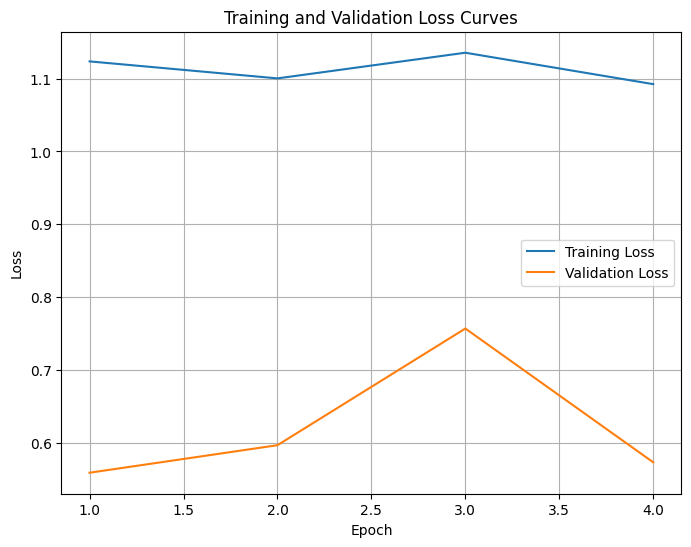

In [48]:
# Extract loss history from trainer logs
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
epochs = range(1, len(eval_loss) + 1)  # Use eval_loss length for epochs


plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss[:len(eval_loss)], label='Training Loss')  # Truncate train_loss to match eval_loss length
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

### 10. Example predictions

In [49]:
# Demonstrate model output on sample tweets
sample_tweets = tweets_data['text'].sample(5, random_state=42).tolist()
sample_encodings = tokenizer(sample_tweets, padding=True, truncation=True, max_length=128, return_tensors='pt')
sample_dataset = TweetDataset(sample_encodings, [0] * len(sample_tweets))  # Dummy labels
sample_predictions = trainer.predict(sample_dataset).predictions.argmax(axis=1)
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
print("\nSample Predictions:")
for tweet, pred in zip(sample_tweets, sample_predictions):
    print(f"Tweet: {tweet}\nPredicted Sentiment: {sentiment_map[pred]}\n")


Sample Predictions:
Tweet:  Enjoy! Family trumps everything
Predicted Sentiment: positive

Tweet:  --of them kinda turns me off of it all.  And then I buy more of them and dig a deeper hole, etc. ;;
Predicted Sentiment: negative

Tweet: Clive it`s my birthday pat me  http://apps.facebook.com/dogbook/profile/view/6386106
Predicted Sentiment: neutral

Tweet:  congrats hey
Predicted Sentiment: positive

Tweet: is texting
Predicted Sentiment: neutral

